In [1]:
# hide
import graphviz

d_y = -0.7
def create_layer(dot, x, n_y, names, prefix, label=None):
    assert(n_y == len(names))
    off_y = ((n_y - 1) / 2.0) * abs(d_y)
    ys = [i * d_y + off_y for i in range(n_y)]
    if label:
        dot.node(prefix+'-1', label, shape="none", pos="{},{}!".format(x, ys[0] + 0.4))
    tags = [prefix + str(i) for i in range(len(names))]
    for tag, name, y in zip(tags, names, ys):
        dot.node(tag, name, shape="square",
                pos="{},{}!".format(x, y))
    return tags

def create_arrows(dot, starts, ends, names=None):
    if names:
        assert(len(starts) * len(ends) == len(names))
    else:
        names = [None] * (len(starts)*len(ends))
    index = 0
    for e in ends:
        for s in starts:
            dot.edge(s, e, label=names[index])
            index += 1

def create_layer2(dot, x, n_y, format, l_name, label=None):
    return create_layer(dot, x, n_y,
        [format.format(i) for i in range(n_y)], l_name, label)

def create_nn(n_in, n_out, hiddens=[]):
    dot = graphviz.Digraph('nn', engine='neato')
    input = create_layer2(dot, 0, n_in, "X[{}]", "input", label="入力")
    x = 2
    h_l  = []
    for i, h in enumerate(hiddens):
        h_l.append(create_layer2(dot, x, h, f"h{i}"+"[{}]", f"h-{i}", label=f"隠れ層{i}"))
        x = x + 2

    output = create_layer2(dot, x, n_out, "ŷ", "o", label="出力")
    h_l.append(output)   

    f_l = input
    for t_l in h_l:
        if len(hiddens) == 0:
            names=['w[{}]'.format(i) for i in range(len(f_l))]
        else:
            names=None
        create_arrows(dot, f_l, t_l, names=names)
        f_l = t_l
    return dot


In [2]:
# hide
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plt_predict(model, axe, X, title):
    xmin, xmax, ymin, ymax = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max(), 
    grid = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/300.0), 
                       np.arange(ymin, ymax, (ymax-ymin)/300.0), indexing='xy')
    g = [[x, y] for x, y in zip(np.hstack(grid[0]), np.hstack(grid[1]))]
    p_g = model.predict(g)
    axe.scatter(grid[0], grid[1], c = p_g, cmap=cm.Pastel1, s = 1)
    axe.set_title(title)


### 2.2.5 ニューラルネットワーク

- 人間の神経細胞の動作にヒントを得た機構
- 複数の入力に対して、それぞれ重みを与え、その合計に対して何らかの活性化関数を適用する

#### 歴史
- 1958年 パーセプトロンが提案
- 1969年 ミンスキーによる批判で研究が下火になる
- 1986年 逆誤差伝搬法による訓練手法が確立
- 1989年頃 畳み込みニューラルネットワーク
- 2010年以降 ディープラーニング

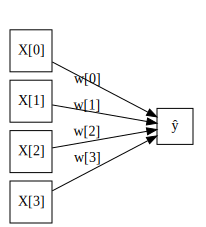

In [3]:
# hide
create_nn(4, 1)


これだけでは、本質的に線形モデルと同一であり、超平面による分割しかできない。ミンスキーによる批判もこれを指摘したものだった。しかし、中間に隠れ層を設けることで非線形分離が可能になる。

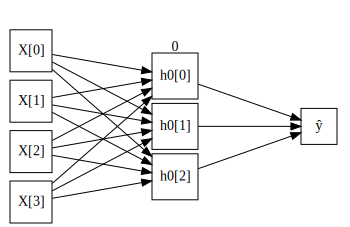

In [4]:
# hide
create_nn(4, 1, hiddens=[3])

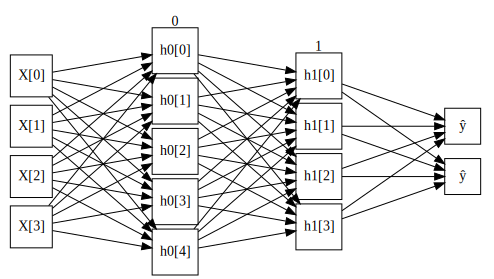

In [5]:
# hidemon
create_nn(4, 2, hiddens=[5, 4])

- 層を増やすことで表現力が増大する
- また、層を増やさずとも、隠れ層1層のニューラルネットワークで任意の関数が任意の精度で近似できることが知られている(普遍性定理)

#### 活性化関数
- ニューラルネットワークの各層は線形変換
    - 線形変換は何度行っても線形変換にしかならない
    - 何層線形変換層があっても同じ
- 層と層の間で非線形変換を挟む
    - 活性化関数(activation function)と呼ぶ
    - 代表的なもの
        - ReLU - Rectified Linear Unit
        - tanh - Hyperbolic tangent
        - sigmoid
- どれを使ってもそれほど大きく結果は変わらない

'代表的な活性化関数'

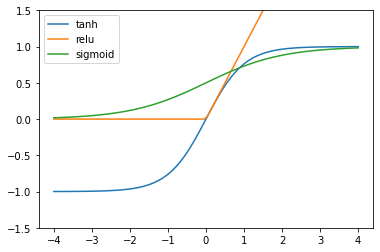

In [6]:
# hide
import matplotlib.pyplot as plt
import numpy as np

line = np.linspace(-4, 4, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.plot(line, 1.0 / (1.0 + np.exp(- line)), label="sigmoid")
plt.ylim(-1.5, 1.5)
plt.legend()
"代表的な活性化関数"


#### 逆誤差伝搬法による訓練
- ニューラルネットワークの重みを、訓練データに対する出力値と正解との誤差から訓練することができる
- ニューラルネットワークの末尾から遡る形で、重みを更新する
- 2000年代の初頭までは、各重みに対する微分値を手で計算してコーディングする必要があったが、現在では自動微分という技術で、自動的に行われるようになった


#### scikit-learn でのNN
- scikit-learnのNNサポートは基本的なもののみでGPUも使わない
    - 本格的な計算を行うにはPyTorchもしくはTensorflowをもちいたほうがいい


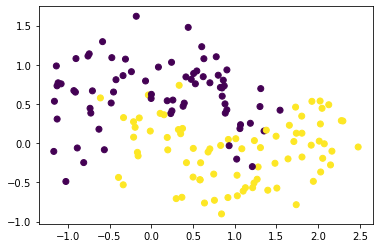

In [7]:
# データの生成と表示
X, y = make_moons(n_samples=200, noise=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)



まず、隠れ層のないNNででの識別を試みる。線形モデルと変わらないことがわかる。

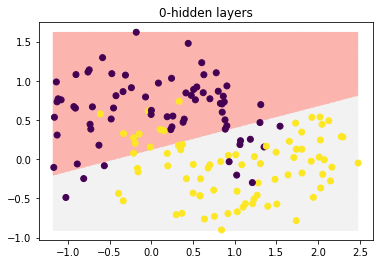

In [8]:
from sklearn.neural_network import MLPClassifier

mdl = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[], activation='relu', max_iter=100000)
mdl.fit(X_train, y_train)
plt_predict(mdl, plt.gca(), X_train, '0-hidden layers')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)


層を増やすと、複雑な境界線を学習することができる。

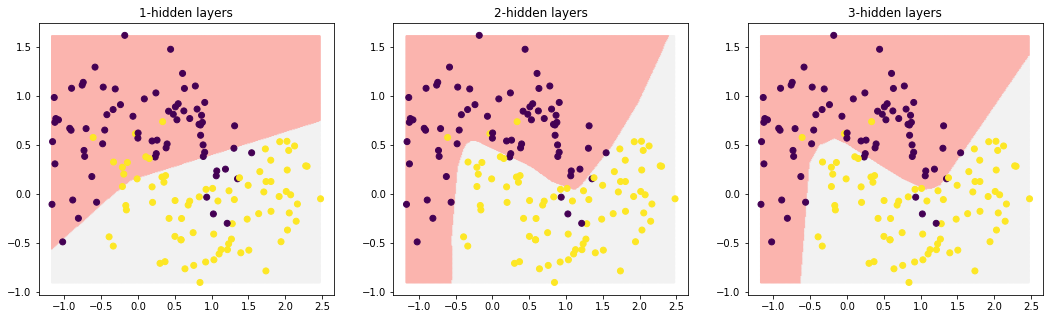

In [9]:
from sklearn.neural_network import MLPClassifier

hiddens=[[10], [10, 10], [10, 10, 10]]

_, axes = plt.subplots(1,3, figsize=(18, 5))
for i, h in enumerate(hiddens):
    mdl = MLPClassifier(solver='adam', hidden_layer_sizes=h, activation='relu', max_iter=100000)
    mdl.fit(X_train, y_train)
    plt_predict(mdl, axes[i], X_train, f'{i+1}-hidden layers')
    axes[i].scatter(X_train[:,0], X_train[:,1], c=y_train)


層を増やさなくても、層のニューロンの数を増やすと、同様に複雑な境界線を学習できる。

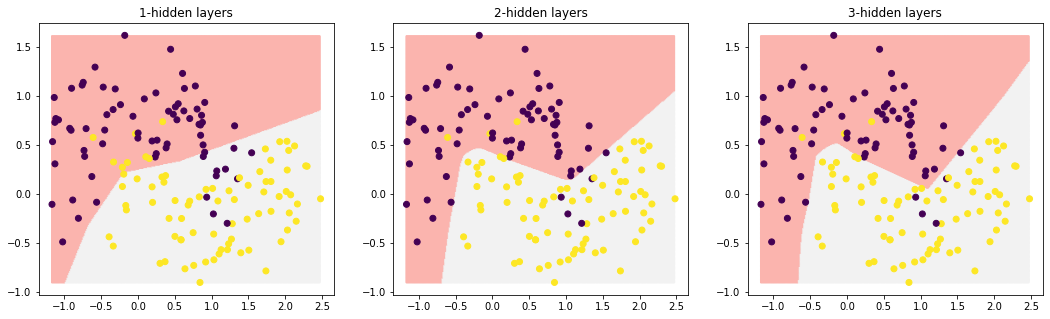

In [10]:
hiddens=[[10], [50], [100]]

_, axes = plt.subplots(1,3, figsize=(18, 5))
for i, h in enumerate(hiddens):
    mdl = MLPClassifier(solver='adam', hidden_layer_sizes=h, activation='relu', max_iter=100000)
    mdl.fit(X_train, y_train)
    plt_predict(mdl, axes[i], X_train, f'{i+1}-hidden layers')
    axes[i].scatter(X_train[:,0], X_train[:,1], c=y_train)

とはいえ、ネットワークの幅を広げるよりは層を増やしたほうがパラメータ数は小さくできる。


まとめ
- 小規模なデータに関しては、ニューラルネットワークには特に優位性はない
- 特徴量の数が大きく、データ量が多い場合にのみ優位性がある
- 小規模データに対しては決定木ベースの手法が優れる